In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             precision_recall_curve, roc_auc_score, roc_curve)

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据
df = pd.read_csv(r'E:\miniconda\ChineseSuperLeague\data\features.csv')
X = df[['home_last3_goals', 'away_last3_concede', 'home_last2_loss']]
y = (df['result'] == 'H').astype(int)

# 2. 分层采样
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [2]:
# 逻辑回归
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# 随机森林
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


======== 逻辑回归 ========
              precision    recall  f1-score   support

         非主胜       0.86      1.00      0.92        30
          主胜       0.00      0.00      0.00         5

    accuracy                           0.86        35
   macro avg       0.43      0.50      0.46        35
weighted avg       0.73      0.86      0.79        35

======== 随机森林 ========
              precision    recall  f1-score   support

         非主胜       0.86      0.83      0.85        30
          主胜       0.17      0.20      0.18         5

    accuracy                           0.74        35
   macro avg       0.51      0.52      0.51        35
weighted avg       0.76      0.74      0.75        35



E:\Miniconda\envs\helloenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\Miniconda\envs\helloenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\Miniconda\envs\helloenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


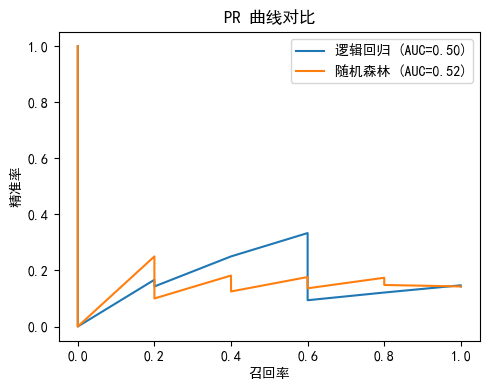

In [3]:
models = {'逻辑回归': lr, '随机森林': rf}
results = {}

for name, clf in models.items():
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    
    results[name] = {
        '准确率': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'PR 曲线': (prec, rec)
    }
    print(f'======== {name} ========')
    print(classification_report(y_test, y_pred, target_names=['非主胜', '主胜']))

# 可视化 PR 曲线
plt.figure(figsize=(5, 4))
for name, res in results.items():
    prec, rec = res['PR 曲线']
    plt.plot(rec, prec, label=f'{name} (AUC={res["AUC"]:.2f})')
plt.xlabel('召回率'); plt.ylabel('精准率'); plt.title('PR 曲线对比')
plt.legend(); plt.tight_layout(); plt.show()

In [5]:
# 以随机森林为例，找 F1 最大阈值
from sklearn.metrics import f1_score
import numpy as np
y_prob_rf = rf.predict_proba(X_test)[:, 1]
ths = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_test, (y_prob_rf >= t).astype(int)) for t in ths]
best_th = ths[np.argmax(f1s)]
print(f'最佳阈值={best_th:.2f}，对应 F1={max(f1s):.2f}')

最佳阈值=0.10，对应 F1=0.27
